In [7]:
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [8]:
# Обучение проводим включительно по эту дату
split_date = "2020-12-30"

In [9]:
interest_rates = ["cbr_g_curve"]
currencies = ["USD", "CHF"]
indexes = ["BRENT", "GOLD", "IMOEX", "RTSI"]
instruments = [
    "APTK",
    "BELU",
    "FESH",
    "MVID",
    "NKNCP",
    "PHOR",
    "PIKK",
    "RASP",
    "SELG",
    "SNGSP",
    # "YNDX",
    "OFZ_26207",
    "OFZ_26209",
    "OFZ_26211",
    "OFZ_26212",
    "OFZ_26218",
]

In [10]:
def concat_data(files):
    df = []
    for file in files:
        df.append(pd.read_csv(file))
    dfs = df[0]
    for x in df[1:]:
        dfs = pd.merge(dfs, x, on=["Date"], how="outer")

    dfs = dfs[(dfs["Date"] >= "2016-01-01") & (dfs["Date"] < "2022-01-01")].copy()
    dfs.set_index("Date", inplace=True)
    dfs.sort_index(inplace=True)
    dfs.index = pd.to_datetime(dfs.index)
    # dfs.dropna(inplace=True)
    return dfs.copy()

In [11]:
path = "./data/{}.csv"
df_risk = [path.format(x) for x in interest_rates + currencies + indexes]
df_risk = concat_data(df_risk)

df_tools = [path.format(x) for x in instruments]
df_tools = concat_data(df_tools)

common_index = pd.merge(df_risk, df_tools, on=["Date"], how="outer").dropna().index
df_risk = df_risk.loc[common_index].copy()
df_tools = df_tools.loc[common_index].copy()

df = pd.merge(df_risk, df_tools, on=["Date"], how="outer")
features_risk = list(df_risk.columns)
features_tools = list(df_tools.columns) + currencies
print(len(df), len(df_risk), len(df_tools))

1109 1109 1109


In [12]:
train_df = df[df.index <= split_date].pct_change().dropna(axis=0)
test_df = df[df.index > split_date].pct_change().dropna(axis=0)
all_df = df.pct_change().dropna(axis=0)

In [81]:
import optuna
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

optuna.logging.set_verbosity(optuna.logging.ERROR)


def get_values(x):
    if isinstance(x, (pd.DataFrame, pd.Series)):
        return x.values
    return x


class Model:
    def __init__(self, n_components=None, pca_args=None, lr_args=None):
        self.pca_args = pca_args or {"random_state": 42}
        self.lr_args = lr_args or {}
        self.pca = PCA(n_components, **self.pca_args)
        self.lr = LinearRegression(**self.lr_args)

    def fit(self, data, target):
        data = get_values(data)
        target = get_values(target)
        data_pca = self.pca.fit_transform(data)
        self.lr.fit(data_pca, target)
        return self

    def predict_pca(self, data):
        data = get_values(data)
        return self.pca.transform(data)

    def predict_lr(self, data):
        return self.lr.predict(data)

    def predict(self, data):
        data = get_values(data)
        return self.lr.predict(self.pca.transform(data))

    def __repr__(self):
        return "{}({}, {})".format(self.__class__.__name__, self.pca, self.lr)


class AutoModel:
    def __init__(self, cv_splits=5, n_trials=10, max_components=10, metric=None):
        self.splitter = TimeSeriesSplit(cv_splits)
        self.study = optuna.study.create_study(sampler=optuna.samplers.TPESampler(seed=42), direction="maximize")
        self.metric = metric or r2_score
        self.n_trials = n_trials
        self.max_components = max_components

    def fit(self, data, target):
        data = get_values(data)
        target = get_values(target)

        def objective(trial):
            components = trial.suggest_int("n_components", 2, min([self.max_components, *data.shape]))
            for t in trial.study.trials:
                if t.state != optuna.trial.TrialState.COMPLETE:
                    continue
                if t.params == trial.params:
                    raise optuna.exceptions.TrialPruned("Duplicate parameter set")

            scores = []
            for train_idx, test_idx in self.splitter.split(data):
                model = Model(components)
                model.fit(data[train_idx], target[train_idx])
                proba = model.predict(data[test_idx])
                score = self.metric(target[test_idx], proba)
                scores.append(score)
            return np.mean(scores)

        self.study.optimize(objective, self.n_trials)
        return Model(**self.study.best_params).fit(data, target)

In [83]:
results = []
instrument_models = {}

for f in features_tools:
    m = AutoModel().fit(train_df[features_risk], train_df[f])
    score = m.predict(train_df[features_risk])
    score_test = m.predict(test_df[features_risk])
    results.append(
        {
            "tool": f,
            "n_components": m.pca.n_components,
            "r2_train": r2_score(train_df[f], score),
            "r2_test": r2_score(test_df[f], score_test),
        }
    )
    instrument_models[f] = m
results = pd.DataFrame(results)
results

,tool,n_components,r2_train,r2_test
0,APTK,5,0.030125,-0.045158
1,BELU,2,0.011270,-0.007362
2,FESH,5,0.093600,-0.058240
3,MVID,2,0.010595,-0.026952
4,NKNCP,5,0.050597,0.043962
5,PHOR,9,0.140284,0.006302
6,PIKK,2,0.029648,0.000659
7,RASP,5,0.162794,0.006060
8,SELG,2,0.032428,0.009306
9,SNGSP,9,0.160947,-0.091917


In [174]:
import copy


class Instrument:
    def __init__(self, name, count, price):
        self.name = name
        self.cnt = count
        self.price = price

    @property
    def cost(self):
        return self.price * self.cnt

    def __repr__(self):
        return "{}({} x {})".format(self.name, self.cnt, self.price)


class Portfolio:
    def __init__(self, tools_with_money, init_prices):
        total = sum(tools_with_money.values())
        self.tools_target = {k: v / total for k, v in tools_with_money.items()}
        self.tools = {
            k: Instrument(k, tools_with_money[k] / init_prices[k], init_prices[k]) for k, v in self.tools_target.items()
        }

    @property
    def cost(self):
        return sum([x.cost for x in self.tools.values()])

    def _tool_rate(self):
        total_cost = self.cost
        return {k: v.cost / total_cost for k, v in self.tools.items()}

    def __getitem__(self, k):
        return self.tools[k]

    def rebalancing(self, new_prices):
        old_cost = self.cost
        old_prices = {k: self[k].price for k in self.tools}
        for k, p in new_prices.items():
            self[k].price = p
        new_cost = self.cost
        for k in self.tools:
            self[k].cnt *= new_cost / old_cost * old_prices[k] / new_prices[k]

        for k, v in self._tool_rate().items():
            assert np.abs(v - self.tools_target[k]) < 0.00001

    def new_cost(self, new_prices):
        new_cost = sum([v.cnt * new_prices[k] for k, v in self.tools.items()])
        return new_cost

    def copy(self):
        return copy.deepcopy(self)

In [56]:
init_tools = {
    "APTK": 1_000_000,
    "BELU": 1_000_000,
    "FESH": 1_000_000,
    "MVID": 1_000_000,
    "NKNCP": 1_000_000,
    "PHOR": 1_000_000,
    "PIKK": 1_000_000,
    "RASP": 1_000_000,
    "SELG": 1_000_000,
    "SNGSP": 1_000_000,
    "OFZ_26207": 10_000_000,
    "OFZ_26209": 10_000_000,
    "OFZ_26211": 10_000_000,
    "OFZ_26212": 10_000_000,
    "OFZ_26218": 10_000_000,
    "USD": 10_000_000,
    "CHF": 10_000_000,
}
p = Portfolio(init_tools, df.iloc[0][features_tools].to_dict())
portfolio_prices = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    p.rebalancing(row[features_tools].to_dict())
    portfolio_prices.append(
        {
            "date": i,
            "price": p.cost,
        }
    )
portfolio_prices = pd.DataFrame(portfolio_prices)

  0%|          | 0/1109 [00:00<?, ?it/s]

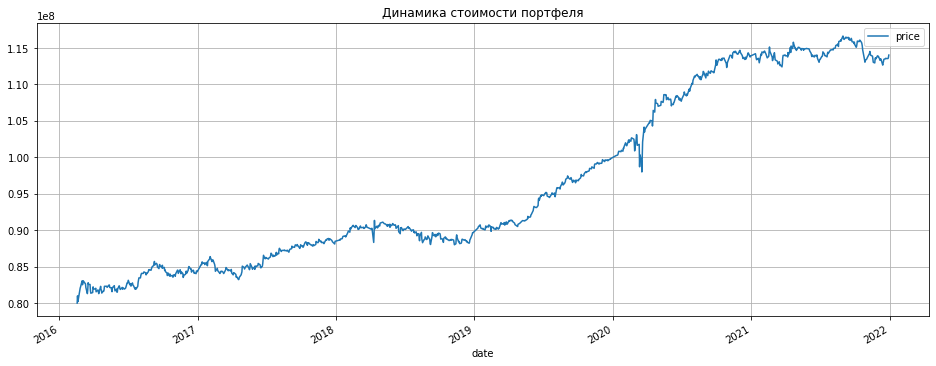

In [63]:
portfolio_prices.plot(x="date", y="price", figsize=(16, 6))
plt.grid()
plt.title("Динамика стоимости портфеля")
plt.show()

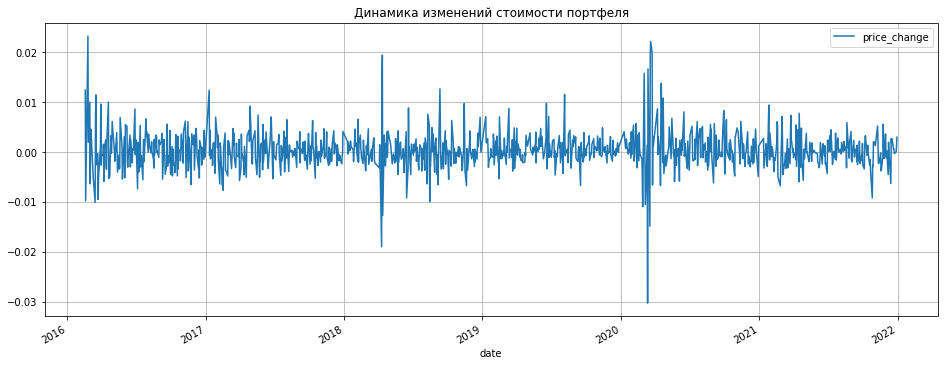

In [66]:
portfolio_prices["price_change"] = portfolio_prices["price"].pct_change()
portfolio_prices.dropna(axis=0).plot(x="date", y="price_change", figsize=(16, 6))
plt.grid()
plt.title("Динамика изменений стоимости портфеля")
plt.show()

In [87]:
def get_step_simulations(data, t, rounds=1000, random_state=42):
    """
    Симуляция процентного приращения риск-фактора на t шагов вперед
    """
    rnd = np.random.RandomState(random_state)
    corr_matrix = np.linalg.cholesky(np.corrcoef(data, rowvar=False))
    rnd_vec = (
        corr_matrix
        @ np.cumsum(np.sqrt(1 / t) * rnd.normal(loc=0, scale=1, size=(data.shape[1], rounds, t)), axis=2)[:, :, -1]
    )
    # здесь вычисляется процентное приращение риск-фактора
    new_vals = np.exp((data.mean(axis=0) - data.std(axis=0) ** 2 / 2) / t + data.std(axis=0) * rnd_vec.T) - 1
    return new_vals

In [92]:
window_size = 30
t = 1

instrument_simulations = []
for f in tqdm(features_tools, total=len(features_tools)):
    m = instrument_models[f]
    pca_df = m.predict_pca(all_df[features_risk])
    simulations = []
    for i in range(len(pca_df) - window_size - t):
        pca_sim = get_step_simulations(pca_df[i : i + window_size], t)
        simulations.append(m.predict_lr(pca_sim))
    instrument_simulations.append(simulations)
instrument_simulations = np.array(instrument_simulations)

  0%|          | 0/17 [00:00<?, ?it/s]

In [100]:
# кол-во инструментов, кол-во дней, кол-во симуляций
instrument_simulations.shape

(17, 1077, 1000)

In [223]:
portfolio_prices_simulations = []
df_ = df.iloc[window_size + t + 1 :].copy()
p = Portfolio(init_tools, df_.iloc[0].to_dict())
for j, (i, row) in tqdm(enumerate(df_.iterrows()), total=len(df_)):
    p.rebalancing(row[features_tools])
    p_sim = []
    p_init = p.cost
    # симуляции по всем инструментам за конкретный день
    new_prices = np.multiply(instrument_simulations[:, j, :].T, row[features_tools].values)  # N, tools
    new_prices = row[features_tools].values + new_prices
    for sim in new_prices:
        p_sim.append(p.new_cost({k: v for k, v in zip(features_tools, sim)}) / p_init - 1)
    portfolio_prices_simulations.append(
        {
            "date": i,
            "price_change": p_sim,
        }
    )
    
portfolio_prices_simulations = pd.DataFrame(portfolio_prices_simulations)

  0%|          | 0/1077 [00:00<?, ?it/s]

In [224]:
portfolio_prices_simulations = pd.DataFrame(portfolio_prices_simulations)

In [225]:
portfolio_prices_simulations["var_99"] = -portfolio_prices_simulations["price_change"].map(
    lambda x: -np.percentile(x, 1)
)

portfolio_prices_simulations["es_97,5"] = -portfolio_prices_simulations["price_change"].map(
    lambda x: -(np.array(x)[np.array(x) < np.percentile(x, 2.5)]).mean()
)

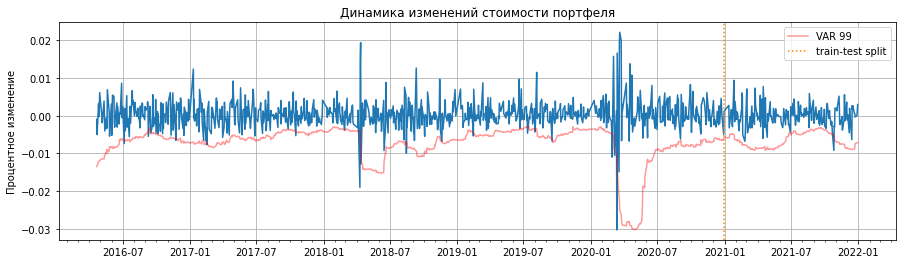

In [231]:
plt.figure(figsize=(15, 4))
idx = portfolio_prices_simulations['date']
plt.plot(idx, portfolio_prices.dropna(axis=0).iloc[window_size + t:]["price_change"])
plt.plot(idx, portfolio_prices_simulations["var_99"], c="r", alpha=0.4, label='VAR 99')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.axvline(pd.to_datetime(split_date), c="tab:orange", linestyle=":", label='train-test split')
plt.title("Динамика изменений стоимости портфеля")
plt.ylabel("Процентное изменение")
plt.grid()
plt.legend()
plt.show()

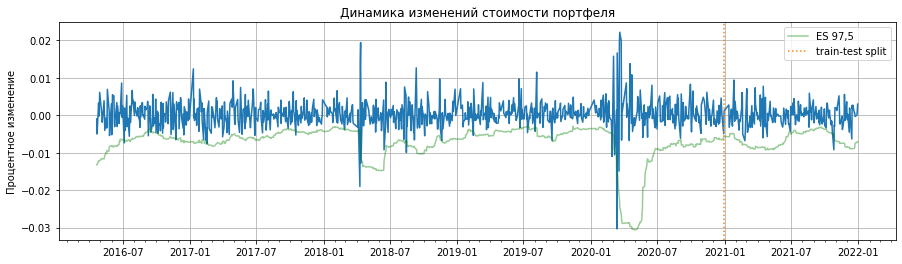

In [230]:
plt.figure(figsize=(15, 4))
idx = portfolio_prices_simulations['date']
plt.plot(idx, portfolio_prices.dropna(axis=0).iloc[window_size + t :]["price_change"])
plt.plot(idx, portfolio_prices_simulations["es_97,5"], c="g", alpha=0.4, label='ES 97,5')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.axvline(pd.to_datetime(split_date), c="tab:orange", linestyle=":", label='train-test split')
plt.title("Динамика изменений стоимости портфеля")
plt.ylabel("Процентное изменение")
plt.grid()
plt.legend()
plt.show()

In [232]:
window_size = 30
t = 10

instrument_simulations = []
for f in tqdm(features_tools, total=len(features_tools)):
    m = instrument_models[f]
    pca_df = m.predict_pca(all_df[features_risk])
    simulations = []
    for i in range(len(pca_df) - window_size - t):
        pca_sim = get_step_simulations(pca_df[i : i + window_size], t)
        simulations.append(m.predict_lr(pca_sim))
    instrument_simulations.append(simulations)
instrument_simulations = np.array(instrument_simulations)

  0%|          | 0/17 [00:00<?, ?it/s]

In [233]:
portfolio_prices_simulations = []
df_ = df.iloc[window_size + t + 1 :].copy()
p = Portfolio(init_tools, df_.iloc[0].to_dict())
for j, (i, row) in tqdm(enumerate(df_.iterrows()), total=len(df_)):
    p.rebalancing(row[features_tools])
    p_sim = []
    p_init = p.cost
    # симуляции по всем инструментам за конкретный день
    new_prices = np.multiply(instrument_simulations[:, j, :].T, row[features_tools].values)  # N, tools
    new_prices = row[features_tools].values + new_prices
    for sim in new_prices:
        p_sim.append(p.new_cost({k: v for k, v in zip(features_tools, sim)}) / p_init - 1)
    portfolio_prices_simulations.append(
        {
            "date": i,
            "price_change": p_sim,
        }
    )
    
portfolio_prices_simulations = pd.DataFrame(portfolio_prices_simulations)

  0%|          | 0/1068 [00:00<?, ?it/s]

In [234]:
portfolio_prices_simulations = pd.DataFrame(portfolio_prices_simulations)

In [235]:
portfolio_prices_simulations["var_99"] = -portfolio_prices_simulations["price_change"].map(
    lambda x: -np.percentile(x, 1)
)

portfolio_prices_simulations["es_97,5"] = -portfolio_prices_simulations["price_change"].map(
    lambda x: -(np.array(x)[np.array(x) < np.percentile(x, 2.5)]).mean()
)

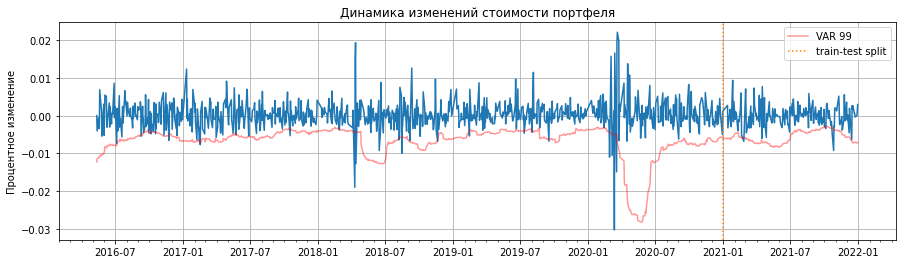

In [236]:
plt.figure(figsize=(15, 4))
idx = portfolio_prices_simulations['date']
plt.plot(idx, portfolio_prices.dropna(axis=0).iloc[window_size + t:]["price_change"])
plt.plot(idx, portfolio_prices_simulations["var_99"], c="r", alpha=0.4, label='VAR 99')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.axvline(pd.to_datetime(split_date), c="tab:orange", linestyle=":", label='train-test split')
plt.title("Динамика изменений стоимости портфеля")
plt.ylabel("Процентное изменение")
plt.grid()
plt.legend()
plt.show()

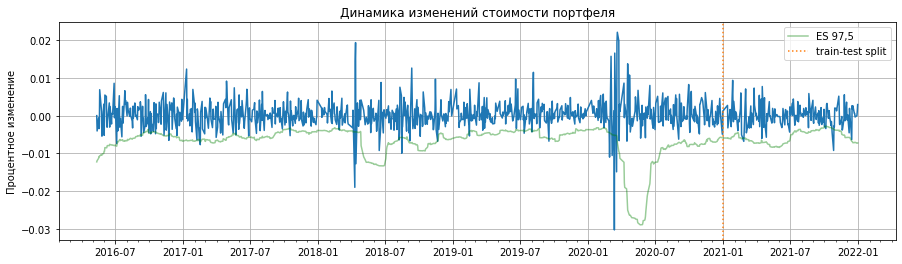

In [237]:
plt.figure(figsize=(15, 4))
idx = portfolio_prices_simulations['date']
plt.plot(idx, portfolio_prices.dropna(axis=0).iloc[window_size + t :]["price_change"])
plt.plot(idx, portfolio_prices_simulations["es_97,5"], c="g", alpha=0.4, label='ES 97,5')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.axvline(pd.to_datetime(split_date), c="tab:orange", linestyle=":", label='train-test split')
plt.title("Динамика изменений стоимости портфеля")
plt.ylabel("Процентное изменение")
plt.grid()
plt.legend()
plt.show()